# Formação Cientista de Dados - Data Science Academy
### Prevendo Customer Churn em Operadoras de Telecom
Projeto com Feedback 4

In [82]:
import re
import pandas as pd
import numpy as np
import seaborn as sns
import scipy.stats as stats
import statsmodels.api as sm
import matplotlib.pyplot as plt
from imblearn.over_sampling import SMOTE
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import RFE
from sklearn.linear_model import LogisticRegression
from sklearn.feature_selection import chi2
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, f1_score, recall_score
from sklearn.ensemble import RandomForestClassifier
from statsmodels.stats.outliers_influence import variance_inflation_factor

### Funções Utilitarias

In [83]:
# Carregar dados
def carrega_dados(nome_arquivo):
    return pd.read_csv(nome_arquivo)

In [84]:
# Gerar gráficos de balanceamento de classes
def plot_balanceamento_classes(classe, titulo):
    classes, counts = np.unique(classe, return_counts=True)
    plt.bar(classes, counts)
    plt.xticks(classes)
    plt.xlabel('Classes')
    plt.ylabel('Número de amostras')
    plt.title(titulo)
    
    for i in range(len(classes)):
        plt.text(x = classes[i] - 0.05, y = counts[i] + 1, s = counts[i])
    
    plt.show()

In [85]:
# Aplicar de label-encoding
def aplica_label_encoding(df, lista_colunas):
    le = LabelEncoder()
    for coluna in lista_colunas:
        df[coluna] = le.fit_transform(df[coluna])
    return df

In [86]:
# Selecionar melhores variaveis para o modelo
def selecionar_melhores_variaveis(x, y, quatidade_variaveis):
    logreg = LogisticRegression(max_iter=1200)
    rfe = RFE(estimator=logreg, n_features_to_select=quatidade_variaveis)
    rfe.fit(x, y)
    return x.columns[rfe.support_]

In [87]:
# Validar se possui/não possui informações
def validar_valores(valor):
    if valor > 0:
        return 1
    else:
        return 0

In [88]:
# Aplicar o SMOTE para balancear as classes
def aplicar_balanceamento_classes(variavel_alvo, variaveis_preditoras):
    smote = SMOTE(random_state=42)
    return smote.fit_resample(variavel_alvo, variaveis_preditoras)

In [89]:
# Gerar gráfico com a média de chamado em relação a clientes com churn ou não
def gerar_grafico_media_chamados_por_churn(df):
    categories = ['Não Churn', 'Churn']

    # Calcular a média de chamadas de serviço ao cliente para cada valor de churn
    churn_calls = df.groupby('churn')['number_customer_service_calls'].sum()

    # Definir as cores das barras
    colors = ['#1f77b4', '#ff7f0e']

    # Criar um gráfico de barras para mostrar as médias de chamadas de serviço ao cliente para cada valor de churn
    plt.bar(categories, churn_calls.values, color=colors)
    plt.title('Quantidade de chamadas de serviço ao cliente por churn')
    plt.xlabel('Cliente Churn')
    plt.ylabel('Quantidade de chamadas de serviço ao cliente')

    # Adicionar os valores das barras no gráfico
    for i, value in enumerate(churn_calls.values):
        plt.text(i, value, str(round(value, 2)), ha='center')

    plt.show()

In [90]:
def gerar_grafico_churn_por_area(df):
    # Criar uma tabela pivô com a contagem de "yes" e "no" por "area_code"
    df_pivot = df.pivot_table(index='area_code', columns='churn', values='state', aggfunc='count')

    # Transformar a tabela pivô em um DataFrame com as colunas "area_code", "churn" e "count"
    df_new = pd.DataFrame(df_pivot.to_records())
    df_new = df_new.rename(columns={'area_code': 'Area Code', 'no': 'Não churn', 'yes': 'Churn'})

    # Plotar um gráfico de barras com as colunas "yes" e "no" lado a lado
    ax = df_new.plot(x='Area Code', kind='bar', rot=0)

    # Adicionar rótulos de valores às barras
    for c in ax.containers:
        for r in c:
            h = r.get_height()
            ax.annotate(f'{h:.0f}', xy=(r.get_x() + r.get_width() / 2, h), 
                        xytext=(0, 3), textcoords="offset points", ha='center', va='bottom')

    # Adicionar rótulos de rótulos à base das barras
    ax.set_xlabel('Área')
    ax.set_ylabel('Quantidade de Churns')
    ax.set_title('Quantidade de Churns por Area')

    # Ajustar o tamanho do gráfico
    fig = ax.get_figure()
    fig.set_size_inches(8, 6)

    # Mostrar o gráfico
    plt.show()

Perguntas que podem ser feitas:

- Qual a porcentagem de churn por area_code?
- Qual o total pago pelo cliente?
- O total pago pelo cliente tem relação com o churn?
- 


### Análise exploratória de dados

In [91]:
# Carregando dados de Treino
df = carrega_dados("datasets/train.csv")

print('dimensões:', df.shape)
print('colunas:', df.columns)

# Analisando dataframe
df.head(5)

dimensões: (3333, 21)
colunas: Index(['Unnamed: 0', 'state', 'account_length', 'area_code',
       'international_plan', 'voice_mail_plan', 'number_vmail_messages',
       'total_day_minutes', 'total_day_calls', 'total_day_charge',
       'total_eve_minutes', 'total_eve_calls', 'total_eve_charge',
       'total_night_minutes', 'total_night_calls', 'total_night_charge',
       'total_intl_minutes', 'total_intl_calls', 'total_intl_charge',
       'number_customer_service_calls', 'churn'],
      dtype='object')


,Unnamed: 0,state,account_length,area_code,international_plan,voice_mail_plan,number_vmail_messages,total_day_minutes,total_day_calls,total_day_charge,...,total_eve_calls,total_eve_charge,total_night_minutes,total_night_calls,total_night_charge,total_intl_minutes,total_intl_calls,total_intl_charge,number_customer_service_calls,churn
0,1,KS,128,area_code_415,no,yes,25,265.1,110,45.07,...,99,16.78,244.7,91,11.01,10.0,3,2.70,1,no
1,2,OH,107,area_code_415,no,yes,26,161.6,123,27.47,...,103,16.62,254.4,103,11.45,13.7,3,3.70,1,no
2,3,NJ,137,area_code_415,no,no,0,243.4,114,41.38,...,110,10.30,162.6,104,7.32,12.2,5,3.29,0,no
3,4,OH,84,area_code_408,yes,no,0,299.4,71,50.90,...,88,5.26,196.9,89,8.86,6.6,7,1.78,2,no
4,5,OK,75,area_code_415,yes,no,0,166.7,113,28.34,...,122,12.61,186.9,121,8.41,10.1,3,2.73,3,no


In [92]:
# Criando dicionario de dados
dic_dados = {
    'Unnamed: 0': 'Índice numérico das linhas do conjunto de dados.',
    'state': 'Estado dos EUA onde o cliente reside.',
    'account_length': 'Tempo que o cliente tem sido assinante da operadora.',
    'area_code': 'Código de área do telefone do cliente.',
    'international_plan': 'Indica se o cliente tem um plano internacional ativado (yes/no).',
    'voice_mail_plan': 'Indica se o cliente tem um plano de correio de voz ativado (yes/no).',
    'number_vmail_messages': 'Número de mensagens de correio de voz que o cliente tem.',
    'total_day_minutes': 'Total de minutos usados durante o dia.',
    'total_day_calls': 'Total de chamadas feitas durante o dia.',
    'total_day_charge': 'Total cobrado pela operadora pelo uso durante o dia.',
    'total_eve_minutes': 'Total de minutos usados durante a noite.',
    'total_eve_calls': 'Total de chamadas feitas durante a noite.',
    'total_eve_charge': 'Total cobrado pela operadora pelo uso durante a noite.',
    'total_night_minutes': 'Total de minutos usados durante a noite.',
    'total_night_calls': 'Total de chamadas feitas durante a noite.',
    'total_night_charge': 'Total cobrado pela operadora pelo uso durante a noite.',
    'total_intl_minutes': 'Total de minutos usados em chamadas internacionais.',
    'total_intl_calls': 'Total de chamadas feitas para números internacionais.',
    'total_intl_charge': 'Total cobrado pela operadora pelo uso de chamadas internacionais.',
    'number_customer_service_calls': 'Número de chamadas feitas pelo cliente ao serviço de atendimento ao cliente.',
    'churn': 'Indica se o cliente cancelou o contrato com a operadora (yes/no).'
}

# Convertendo lista de dicionários em DataFrame
#dicionario_dados = pd.DataFrame([{'variavel': k, 'descricao': v} for k, v in dic_dados.items()])
dic_dados

{'Unnamed: 0': 'Índice numérico das linhas do conjunto de dados.',
 'state': 'Estado dos EUA onde o cliente reside.',
 'account_length': 'Tempo que o cliente tem sido assinante da operadora.',
 'area_code': 'Código de área do telefone do cliente.',
 'international_plan': 'Indica se o cliente tem um plano internacional ativado (yes/no).',
 'voice_mail_plan': 'Indica se o cliente tem um plano de correio de voz ativado (yes/no).',
 'number_vmail_messages': 'Número de mensagens de correio de voz que o cliente tem.',
 'total_day_minutes': 'Total de minutos usados durante o dia.',
 'total_day_calls': 'Total de chamadas feitas durante o dia.',
 'total_day_charge': 'Total cobrado pela operadora pelo uso durante o dia.',
 'total_eve_minutes': 'Total de minutos usados durante a noite.',
 'total_eve_calls': 'Total de chamadas feitas durante a noite.',
 'total_eve_charge': 'Total cobrado pela operadora pelo uso durante a noite.',
 'total_night_minutes': 'Total de minutos usados durante a noite.',


In [93]:
# Selecionando coluna de indice
colunas_deletar = ['Unnamed: 0']

# Selecionando colunas com valores semelhantes
#colunas_deletar = colunas_deletar + ['area_code']
print('colunas que serão removidas:', colunas_deletar)

colunas que serão removidas: ['Unnamed: 0']


In [94]:
# Analisando dados que serão excluidos
df_colunas_deletar = df[colunas_deletar]
df_colunas_deletar.head(10)

,Unnamed: 0
0,1
1,2
2,3
3,4
4,5
5,6
6,7
7,8
8,9
9,10


In [95]:
# Removendo colunas
dados = df.drop(colunas_deletar, axis=1)

In [96]:
# Analisando dataframe após remover as colunas
print('dimensões:', dados.shape)
print('tipos das variáveis:\n', dados.dtypes)

dados.head(5)

dimensões: (3333, 20)
tipos das variáveis:
 state                             object
account_length                     int64
area_code                         object
international_plan                object
voice_mail_plan                   object
number_vmail_messages              int64
total_day_minutes                float64
total_day_calls                    int64
total_day_charge                 float64
total_eve_minutes                float64
total_eve_calls                    int64
total_eve_charge                 float64
total_night_minutes              float64
total_night_calls                  int64
total_night_charge               float64
total_intl_minutes               float64
total_intl_calls                   int64
total_intl_charge                float64
number_customer_service_calls      int64
churn                             object
dtype: object


,state,account_length,area_code,international_plan,voice_mail_plan,number_vmail_messages,total_day_minutes,total_day_calls,total_day_charge,total_eve_minutes,total_eve_calls,total_eve_charge,total_night_minutes,total_night_calls,total_night_charge,total_intl_minutes,total_intl_calls,total_intl_charge,number_customer_service_calls,churn
0,KS,128,area_code_415,no,yes,25,265.1,110,45.07,197.4,99,16.78,244.7,91,11.01,10.0,3,2.70,1,no
1,OH,107,area_code_415,no,yes,26,161.6,123,27.47,195.5,103,16.62,254.4,103,11.45,13.7,3,3.70,1,no
2,NJ,137,area_code_415,no,no,0,243.4,114,41.38,121.2,110,10.30,162.6,104,7.32,12.2,5,3.29,0,no
3,OH,84,area_code_408,yes,no,0,299.4,71,50.90,61.9,88,5.26,196.9,89,8.86,6.6,7,1.78,2,no
4,OK,75,area_code_415,yes,no,0,166.7,113,28.34,148.3,122,12.61,186.9,121,8.41,10.1,3,2.73,3,no


In [97]:
# Analisando coluna area_code
print('Valores únicos:', dados.area_code.unique())

# Aplicando regex para extrair somento o numero do texto
dados['area_code'] = dados.area_code.str.extract('(\d+)')

# Conferindo o resultado
print('Valores modificados:', dados.area_code.unique())

Valores únicos: ['area_code_415' 'area_code_408' 'area_code_510']
Valores modificados: ['415' '408' '510']


In [98]:
churn_por_area = dados.groupby('area_code')['churn'].value_counts()

maior_contagem = churn_por_area.max()
area_maior_contagem = churn_por_area[churn_por_area == maior_contagem].index.get_level_values(0)[0]

print("A área com o maior número de churns é a {}.".format(area_maior_contagem))

A área com o maior número de churns é a 415.


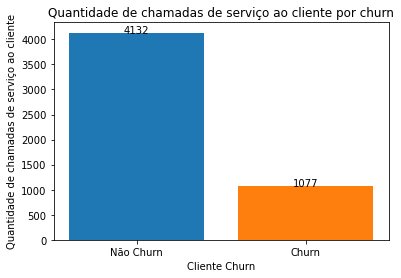

In [99]:
# Analisando a quantidade de chamados por clientes churn ou não
gerar_grafico_media_chamados_por_churn(dados)

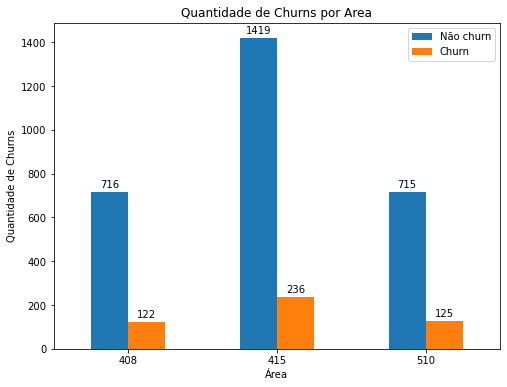

In [100]:
# Analisando quantidade de churn por área
gerar_grafico_churn_por_area(dados)

In [101]:
# Analisando área com maior número de cancelamentos
df_maior_valor_churn = dados.loc[(dados['area_code'] == str(area_maior_contagem)) & (dados['churn'] == 'yes')]
print('dimenssões:', df_maior_valor_churn.shape)
df_maior_valor_churn.head(5)

dimenssões: (236, 20)


,state,account_length,area_code,international_plan,voice_mail_plan,number_vmail_messages,total_day_minutes,total_day_calls,total_day_charge,total_eve_minutes,total_eve_calls,total_eve_charge,total_night_minutes,total_night_calls,total_night_charge,total_intl_minutes,total_intl_calls,total_intl_charge,number_customer_service_calls,churn
10,IN,65,415,no,no,0,129.1,137,21.95,228.5,83,19.42,208.8,111,9.40,12.7,6,3.43,4,yes
15,NY,161,415,no,no,0,332.9,67,56.59,317.8,97,27.01,160.6,128,7.23,5.4,9,1.46,4,yes
48,ID,119,415,no,no,0,159.1,114,27.05,231.3,117,19.66,143.2,91,6.44,8.8,3,2.38,5,yes
54,WY,87,415,no,no,0,151.0,83,25.67,219.7,116,18.67,203.9,127,9.18,9.7,3,2.62,5,yes
76,DC,82,415,no,no,0,300.3,109,51.05,181.0,100,15.39,270.1,73,12.15,11.7,4,3.16,0,yes


In [102]:
# Verificar se precisa tratar outlier da variavel number_vmail_messages

# Analisando variáveis que podem ser modificadas por sim/não
print('valores de number_vmail_messages:', dados['number_vmail_messages'].unique())
print('valores de number_customer_service_calls:', dados['number_customer_service_calls'].unique())
dados.sample(5)

valores de number_vmail_messages: [25 26  0 24 37 27 33 39 30 41 28 34 46 29 35 21 32 42 36 22 23 43 31 38
 40 48 18 17 45 16 20 14 19 51 15 11 12 47  8 44 49  4 10 13 50  9]
valores de number_customer_service_calls: [1 0 2 3 4 5 7 9 6 8]


,state,account_length,area_code,international_plan,voice_mail_plan,number_vmail_messages,total_day_minutes,total_day_calls,total_day_charge,total_eve_minutes,total_eve_calls,total_eve_charge,total_night_minutes,total_night_calls,total_night_charge,total_intl_minutes,total_intl_calls,total_intl_charge,number_customer_service_calls,churn
1689,WY,90,408,no,yes,39,94.8,89,16.12,219.1,91,18.62,197.4,65,8.88,11.4,5,3.08,1,no
2841,AZ,100,510,no,no,0,78.7,98,13.38,225.6,102,19.18,150.4,106,6.77,14.0,8,3.78,0,no
1337,WY,97,510,yes,no,0,236.9,107,40.27,157.6,105,13.40,241.0,120,10.85,7.3,2,1.97,0,yes
972,LA,87,415,no,no,0,228.7,90,38.88,163.0,99,13.86,154.1,90,6.93,11.8,3,3.19,1,no
3201,MN,59,408,no,yes,32,211.9,120,36.02,202.9,136,17.25,213.5,95,9.61,8.8,5,2.38,1,no


In [103]:
# Está tecnica aplicada apresentou piora na performance do modelo 
# Modificando colunas de valores numericos para binários
# df_modificado['number_vmail_messages'] = df_modificado['number_vmail_messages'].apply(validar_valores)
# df_modificado['number_customer_service_calls'] = df_modificado['number_customer_service_calls'].apply(validar_valores)
# df_modificado.sample(5)

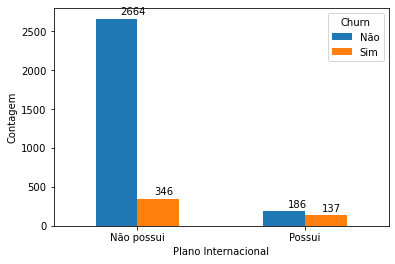

In [104]:
# Criando um DataFrame com a contagem de churn e não churn para clientes com e sem plano internacional
intl_counts = dados.groupby(["international_plan", "churn"]).size().unstack()

intl_counts.index = ['Não possui', 'Possui']

intl_counts.plot(kind="bar")

# Configurando os eixos e a legenda
plt.xlabel("Plano Internacional")
plt.ylabel("Contagem")
plt.legend(title="Churn", labels=["Não", "Sim"])
plt.xticks(rotation=0)

for i in range(len(intl_counts.index)):
    plt.text(x = i - 0.1, y = intl_counts.iloc[i,0] + 50, s = intl_counts.iloc[i,0], size = 10)
    plt.text(x = i + 0.1, y = intl_counts.iloc[i,1] + 50, s = intl_counts.iloc[i,1], size = 10)


# Exibindo o gráfico
plt.show()

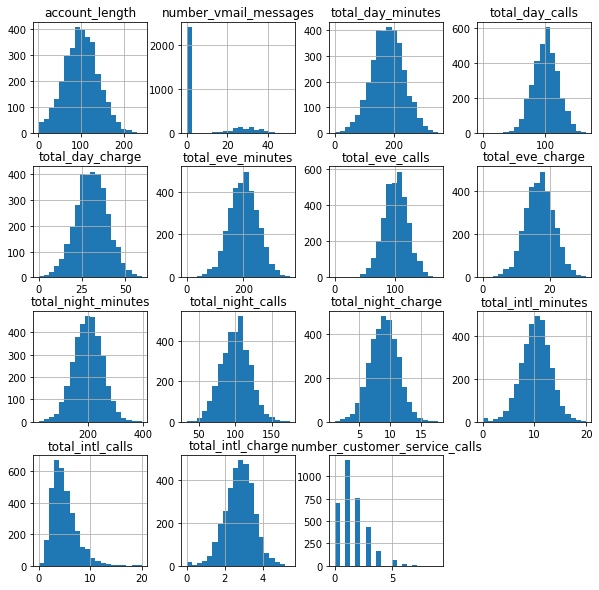

In [105]:
# Analisando distribuição dos dados
dados.hist(bins=20, figsize=(10,10))
plt.show()

### Tratamento dos dados

In [106]:
# Criando coluna total_charges para representar o valor total cobrado pela operadora
dados['total_charge'] = dados.total_day_charge + dados.total_eve_charge + dados.total_night_charge + dados.total_intl_charge
dados.head(5)

,state,account_length,area_code,international_plan,voice_mail_plan,number_vmail_messages,total_day_minutes,total_day_calls,total_day_charge,total_eve_minutes,...,total_eve_charge,total_night_minutes,total_night_calls,total_night_charge,total_intl_minutes,total_intl_calls,total_intl_charge,number_customer_service_calls,churn,total_charge
0,KS,128,415,no,yes,25,265.1,110,45.07,197.4,...,16.78,244.7,91,11.01,10.0,3,2.70,1,no,75.56
1,OH,107,415,no,yes,26,161.6,123,27.47,195.5,...,16.62,254.4,103,11.45,13.7,3,3.70,1,no,59.24
2,NJ,137,415,no,no,0,243.4,114,41.38,121.2,...,10.30,162.6,104,7.32,12.2,5,3.29,0,no,62.29
3,OH,84,408,yes,no,0,299.4,71,50.90,61.9,...,5.26,196.9,89,8.86,6.6,7,1.78,2,no,66.80
4,OK,75,415,yes,no,0,166.7,113,28.34,148.3,...,12.61,186.9,121,8.41,10.1,3,2.73,3,no,52.09


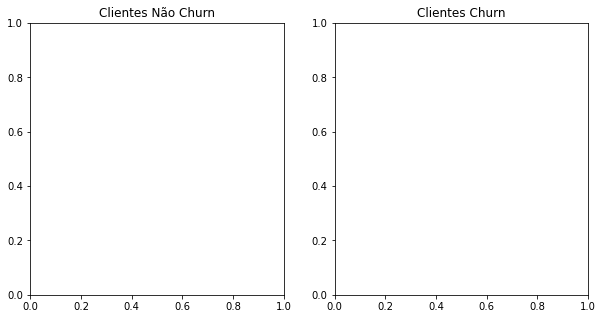

É possivel visualizar que entre os clientes com churn, a maior concentração destes está em clientes que foram cobrados pela operadora em torno de 75 ~ 80, seguidos por 50 ~ 55.


In [107]:
# Criando dois dataframes separados, um para churn=0 e outro para churn=1
dados_churn_0 = dados[dados["churn"] == 0]
dados_churn_1 = dados[dados["churn"] == 1]

# Criando dois subplots, um para churn=0 e outro para churn=1
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(10,5))

# Criando o histograma para churn=0
sns.histplot(data=dados_churn_0, x="total_charge", ax=axes[0])
axes[0].set_title("Clientes Não Churn")

# Criando o histograma para churn=1
sns.histplot(data=dados_churn_1, x="total_charge", ax=axes[1])
axes[1].set_title("Clientes Churn")

# Exibindo os gráficos
plt.show()
print('É possivel visualizar que entre os clientes com churn, a maior concentração destes está em clientes que foram cobrados pela operadora em torno de 75 ~ 80, seguidos por 50 ~ 55.')

In [117]:
df_total_charge_por_churn = dados[(dados['churn'] == 'yes')  & ((dados['total_charge'] >= 75) & (dados['total_charge'] <= 80) | (dados['total_charge'] >= 50) & (dados['total_charge'] <= 55))]
df_problematicos = df_total_charge_por_churn[['account_length', 'total_charge', 'number_customer_service_calls', 'churn']]
df_problematicos.sample(10)

,account_length,total_charge,number_customer_service_calls,churn
2950,133,51.13,0,yes
3168,201,78.15,1,yes
1768,115,50.47,2,yes
2542,19,77.48,1,yes
2327,82,50.58,6,yes
1532,103,50.84,0,yes
2432,75,52.35,4,yes
1284,135,77.48,5,yes
2412,89,78.86,1,yes
2968,160,76.57,1,yes


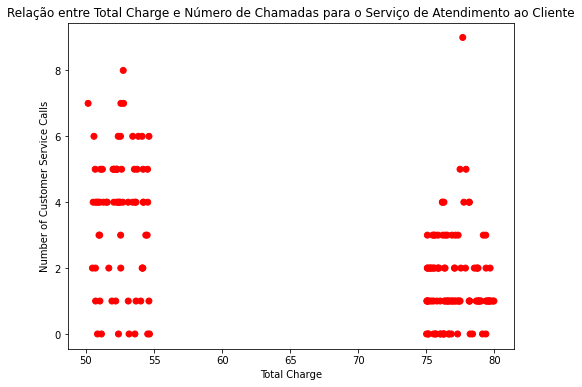

In [118]:
plt.figure(figsize=(8, 6))
colors = {'yes': 'red', 'no': 'blue'}

plt.scatter(df_problematicos['total_charge'], df_problematicos['number_customer_service_calls'], 
            c=df_problematicos['churn'].apply(lambda x: colors[x]))

plt.xlabel('Total Charge')
plt.ylabel('Number of Customer Service Calls')
plt.title('Relação entre Total Charge e Número de Chamadas para o Serviço de Atendimento ao Cliente')

plt.show()


In [119]:
print('aqui podemos ver que entre os clientes com maior indice de cancelamento, quanto maior o valor cobrado pela operador, menos chamadas ao suporte são feitas.')

aqui podemos ver que entre os clientes com maior indice de cancelamento, quanto maior o valor cobrado pela operador, menos chamadas ao suporte são feitas.


In [ ]:
# Selecionando variáveis categóricas
variaveis_categoricas = dados.select_dtypes(include='object')

In [ ]:
# Analisando valores únicos das variáveis categóricas
for v in variaveis_categoricas:
    print('valores únicos da variável', v, ':', list(dados[v].unique()))

print('\ncolunas modificadas:', list(variaveis_categoricas.columns))

In [ ]:
# Aplicando label-encoding nas variáveis categóricas
dados = aplica_label_encoding(dados, variaveis_categoricas.columns)
dados.head(5)

In [ ]:
# Analisando correlação das variáveis preditoras com a variável alvo

# Separando as variáveis preditoras e alvo
variavel_alvo = dados['churn']
variaveis_preditoras = dados.drop('churn', axis=1)

# Criando a matriz de correlação
matriz_correlacao_alvo = variaveis_preditoras.corrwith(variavel_alvo).sort_values(ascending=False)
matriz_correlacao_alvo = pd.DataFrame({'variavel': matriz_correlacao_alvo.index, 'correlacao': matriz_correlacao_alvo.values})

print(matriz_correlacao_alvo)

In [ ]:
# Analisando correlação das variáveis

# Temos 2 possibilidade de remoção, definindo uma quantidade ou os numeros iniciais de cada correlação
#colunas_baixa_correlacao = matriz_correlacao_alvo.iloc[(matriz_correlacao_alvo['correlacao'] - 0).abs().argsort()[:4]]
colunas_baixa_correlacao = list(matriz_correlacao_alvo[matriz_correlacao_alvo["correlacao"].astype(str).str.startswith("0.00")]['variavel'])
print('colunas com baixa correlação:', colunas_baixa_correlacao)

In [ ]:
# Removendo variáveis com baixo nível correlação
# Não é necessário remover
#df = df_modificado.drop(colunas_baixa_correlacao, axis=1)
#df = dados
print('\ndimensões:', df.shape)
df.head(3)

In [ ]:
""" # Aplicando análise de Variance inflation factor (VIF)
# Selecionando variável alvo
variaveis_preditoras = dados.drop('churn', axis=1)

# Criando constante
X = sm.add_constant(variaveis_preditoras)

# Criando modelo
model = sm.OLS(dados['churn'], X)

# Treinando o modelo
results = model.fit()

# Calculando o VIF para cada variável
vif = pd.DataFrame()
vif["VIF Factor"] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]
vif["features"] = X.columns
vif

#  Selecionando variáveis com alto indice VIF
colunas_alto_vif = vif[(vif["features"] != "const") & (vif["VIF Factor"] > 5)]
colunas_alto_vif = colunas_alto_vif["features"].values
colunas_alto_vif

# Removendo variáveis com alto indice VIF
print('Após testes realizados, constatei que tivemos um aumento de mais de 3% de acurácia não removendo as variáveis.')
#df = df.drop(colunas_alto_vif, axis=1)
#print('dimensões:', df.shape)
#df.head(3) """

In [ ]:
# Analisando a distribuição das classes
plot_balanceamento_classes(dados['churn'], 'Distribuição das classes no DataFrame original')

In [ ]:
# Separando varáveis preditoras e alvo
variavel_alvo = dados.drop('churn', axis=1)
variaveis_preditoras = dados['churn']

In [ ]:
# Aplicando balanceamento de classes
x_balanceado, y_balanceado = aplicar_balanceamento_classes(variavel_alvo, variaveis_preditoras)

In [ ]:
# Analisando a distribuição das classes após balanceamento
plot_balanceamento_classes(y_balanceado, 'Distribuição das classes após a aplicação do SMOTE')

In [ ]:
x_balanceado.sample(5)

In [ ]:
# Selecionando variáveis numéricas
lista_colunas_nao_numericas = ['international_plan', 'voice_mail_plan']

colunas_numericas = x_balanceado.drop(lista_colunas_nao_numericas, axis=1)
print('lista_colunas_numericas:', colunas_numericas.columns)

# Criando o StandardScaler para aplicar nas variáveis
scaler = StandardScaler()

In [ ]:
# Analisando valores que serão normalizados.
t = x_balanceado[colunas_numericas.columns].head(5)

In [ ]:
# Aplicando padronização
x_balanceado[colunas_numericas.columns] = scaler.fit_transform(colunas_numericas)

In [ ]:
x_balanceado.head(5)

In [ ]:
# Selecionando as melhores variáveis para o modelo
melhores_variaveis = selecionar_melhores_variaveis(x_balanceado, y_balanceado, 11)

# Exibindo as variáveis selecionadas
print("Variáveis selecionadas:", melhores_variaveis)

In [ ]:
# Analisando dados atuais
x_balanceado.sample(10)

In [ ]:
# Analisando dados somente com as variáveis selecionadas
x_balanceado = x_balanceado[melhores_variaveis]
x_balanceado.head(5)

### Modelo de Regressão Logística

In [ ]:
# Dividindo o conjunto de dados em treino e teste
x_treino, x_teste, y_treino, y_teste = train_test_split(x_balanceado, y_balanceado, test_size=0.3, random_state=42)

In [ ]:
# Criando o modelo
model = LogisticRegression()

In [ ]:
# Trinando o modelo
model.fit(x_treino, y_treino)

In [ ]:
# Fazendo previsões
y_pred = model.predict(x_teste)

In [ ]:
# Avaliando o modelo
accuracy = accuracy_score(y_teste, y_pred)
recall = recall_score(y_teste, y_pred)
f1 = f1_score(y_teste, y_pred)
auc_roc = roc_auc_score(y_teste, y_pred)

In [ ]:
print("Acurácia: {:.2f}%".format(accuracy * 100))
print("Recall: {:.2f}%".format(recall * 100))
print("F1-score: {:.2f}%".format(f1 * 100))
print("AUC-ROC: {:.2f}%".format(auc_roc * 100))